# № 2 День недели и продажи

**Определение гипотез**  

H₀: Средний объём продаж одинаковый в разные дни недели.  
H₁: Есть статистически значимые различия в продажах между днями   

**Тесты**  
- ANOVA (предпосылки не выполнены, тест не проводился)
  - Shapiro-Wilk
  - Kolmogorov-Smirnov
  - Bartlett's test 
  - Levene's test
- Kruskal-Wallis
    - Пост-хок Mann-Whitney (Holm-Bonferroni)

### Загрузка данных

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sqlalchemy
import configparser
import numpy as np
import scipy.stats as stats
import itertools
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import multipletests
 # Импортируем класс из файла db_connection.py
from db_connection import PostgresConnection
# Импортируем класс из файла data_cleaner.py
from data_cleaner import DataCleaner

In [22]:
# Создаем объект для работы с базой данных
db_connection = PostgresConnection()

query = 'SELECT * FROM sales'
data = db_connection.execute_query(query)

### Подготовка данных

In [23]:
# Создаем объект DataCleaner с данным DataFrame
cleaner = DataCleaner(data)

# Удаляем строки с отрицательными значениями в 'dr_sdisc' и 'dr_kol'
cleaned_data = cleaner.drop_negative_values()

# Удаляем строки, где 'dr_nchk' имеет значения из списка [21, 593, 2495]
cleaned_data = cleaner.drop_error_check_values()

### Формирование чеков

In [24]:
cleaned_data['price_without_discount'] = cleaned_data['dr_croz'] * cleaned_data['dr_kol']
grouped = cleaned_data.groupby(['dr_apt', 'dr_nchk', 'dr_dat']).agg({'price_without_discount':'sum',\
                                                            'dr_sdisc':'max', 'dr_tpay':'max'}).reset_index()
grouped['final_price'] = grouped['price_without_discount'] - grouped['dr_sdisc']
grouped.head()

,dr_apt,dr_nchk,dr_dat,price_without_discount,dr_sdisc,dr_tpay,final_price
0,2,1,2022-06-02,1282.0,0.00,15,1282.00
1,2,3,2022-06-02,208.0,6.00,15,202.00
2,2,5,2022-06-02,2124.0,36.52,15,2087.48
3,2,7,2022-06-02,95.0,0.00,18,95.00
4,2,9,2022-06-02,4018.0,200.00,15,3818.00


### EDA

**Формирование выборок**

In [25]:
ru_map = {
    'Monday': 'понедельник', 'Tuesday': 'вторник', 'Wednesday': 'среда',
    'Thursday': 'четверг', 'Friday': 'пятница', 'Saturday': 'суббота',
    'Sunday': 'воскресенье'
}      
grouped['day_of_week'] = pd.to_datetime(grouped['dr_dat']).dt.day_name().map(ru_map)
grouped.head()

,dr_apt,dr_nchk,dr_dat,price_without_discount,dr_sdisc,dr_tpay,final_price,day_of_week
0,2,1,2022-06-02,1282.0,0.00,15,1282.00,четверг
1,2,3,2022-06-02,208.0,6.00,15,202.00,четверг
2,2,5,2022-06-02,2124.0,36.52,15,2087.48,четверг
3,2,7,2022-06-02,95.0,0.00,18,95.00,четверг
4,2,9,2022-06-02,4018.0,200.00,15,3818.00,четверг


**Статистика по группам**

In [26]:
grouped.groupby('day_of_week')['final_price'].agg(
    mean='mean',
    median='median',
    count='count'
).reset_index().round(2)

,day_of_week,mean,median,count
0,воскресенье,563.97,310.00,2819
1,вторник,576.90,309.00,3307
2,понедельник,581.06,329.00,2802
3,пятница,596.52,328.00,2824
4,среда,625.15,334.00,3392
5,суббота,561.67,304.00,2531
6,четверг,584.35,320.07,3247


**Визуализация распределений**

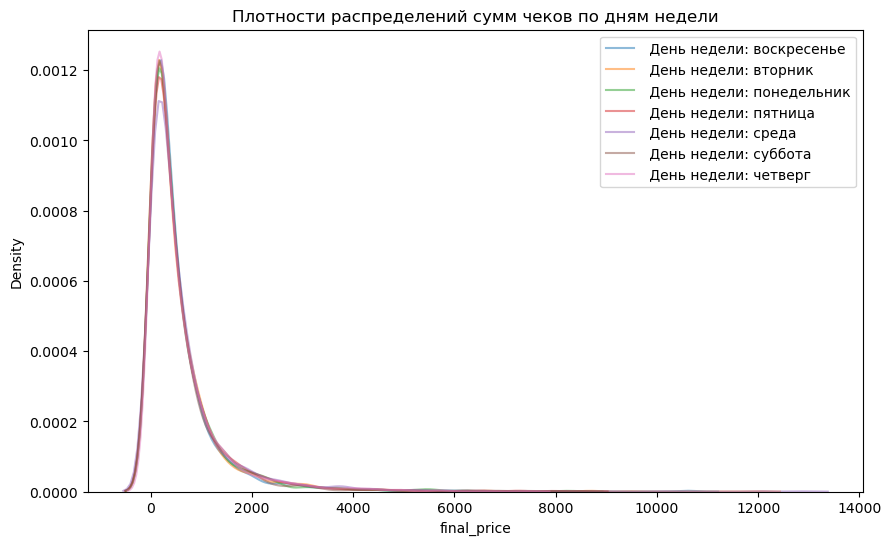

In [27]:
# Группировка по дням недели
groups = grouped.groupby('day_of_week')['final_price']

# 1. --Визуализация плотностей KDE
plt.figure(figsize=(10, 6))
for name, group in groups:
    sns.kdeplot(group, label=f" День недели: {name}", alpha=0.5)
plt.title("Плотности распределений сумм чеков по дням недели")
plt.xlabel("final_price")
#plt.legend()
plt.legend(loc='best')
plt.show()

- Все кривые имеют пик вблизи нуля – нескольких сотен рублей, следовательно большинство чеков в обеих группах находятся в этой зоне.  
- Хвосты (справа) длинные, есть редкие большие чеки (до 14 000).  
- Форма во всех группах очень похожа: узкий высокий пик + длинный правый хвост.  

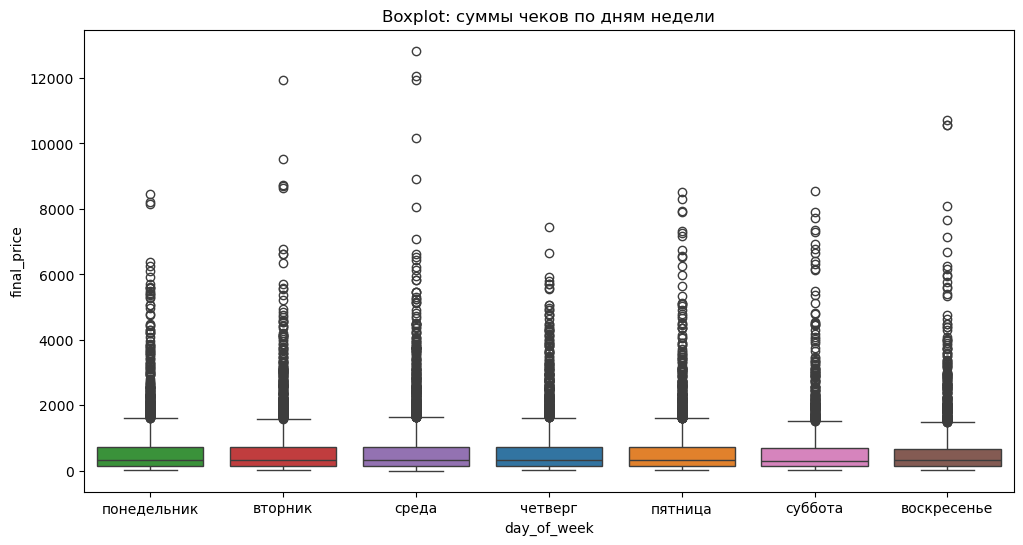

In [36]:
# 2. --Boxplot — сравнение распределений по медианам и разбросу
plt.figure(figsize=(12, 6))
sns.boxplot(x="day_of_week", y="final_price", data=grouped, hue ="day_of_week", 
            order=["понедельник","вторник","среда","четверг","пятница","суббота","воскресенье"])
plt.title("Boxplot: суммы чеков по дням недели")
plt.show()

1. Форма ящиков примерно одинакова:  
    - Ширина IQR (межквартильного размаха) похожа  
    - Расстояние между медианой и краями ящика визуально схоже  
2. Медианы незначительно колеблются  
3. Усы (whiskers) тоже примерно одинаковой длины, следовательно разброс внутри групп схож.  
4. Аномалии/выбросы (точки) присутствуют во всех группах, но в похожем объёме и диапазоне.  

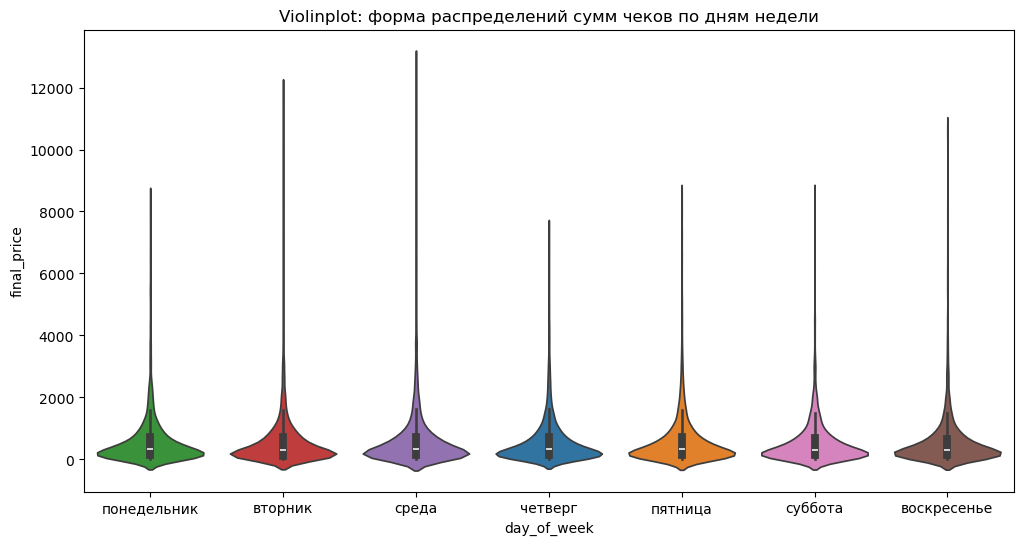

In [37]:
# 3. --Violinplot — форма распределения (сглаженная плотность)
plt.figure(figsize=(12, 6))
sns.violinplot(x="day_of_week", y="final_price", data=grouped,hue ="day_of_week", 
               order=["понедельник","вторник","среда","четверг","пятница","суббота","воскресенье"])
plt.title("Violinplot: форма распределений сумм чеков по дням недели")
plt.show()

1. Форма распределений по дням недели:  
- Все распределения правосторонние (асимметрия вправо) — т.е. большинство чеков небольшие, но есть длинный "хвост" с высокими значениями.  
- Форма у всех похожа — узкий пик у нуля и длинный хвост.  
- Это говорит о сходстве распределений по форме, что важно для Kruskal–Wallis.  

2. Высота и ширина "виол":  
- Ширина показывает плотность данных. В большинстве случаев — пик в области до 500.  
- Нет выраженных различий между днями по плотности — ни один день не имеет кардинально другую форму.  

3. Медианы и IQR (внутри белого прямоугольника):  
- Есть небольшие отличия по медианам, особенно, например, у среды и пятницы.  
- Но это нормально, т.к. Kruskal–Wallis проверяет, отличаются ли медианы статистически.  


## ANOVA

### Проверка предпосылок

In [30]:
# ============================
# 1. Проверка предпосылок
# ============================

print("=== Проверка нормальности (Shapiro + KS) ===")
for day, group in grouped.groupby("day_of_week"):
    stat_shapiro, p_shapiro = stats.shapiro(group["final_price"])
    mean, std = group["final_price"].mean(), group["final_price"].std()
    stat_ks, p_ks = stats.kstest(group["final_price"], "norm", args=(mean, std))
 
    print(f"\nДень: {day}")
    print(f"Shapiro-Wilk: stat={stat_shapiro:.4f}, p={p_shapiro:.4f}")
    print(f"Kolmogorov-Smirnov: stat={stat_ks:.4f}, p={p_ks:.4f}")
    
# Проверка гомогенности дисперсий
groups = [group["final_price"].values for _, group in grouped.groupby("day_of_week")]
 
print("\n=== Проверка гомогенности дисперсий (Bartlett's test + Levene's test) ===")
stat_levene, p_levene = stats.levene(*groups)
stat_bartlett, p_bartlett = stats.bartlett(*groups)
print(f"Levene: stat={stat_levene:.4f}, p={p_levene:.4f}")
print(f"Bartlett: stat={stat_bartlett:.4f}, p={p_bartlett:.4f}")

=== Проверка нормальности (Shapiro + KS) ===

День: воскресенье
Shapiro-Wilk: stat=0.5744, p=0.0000
Kolmogorov-Smirnov: stat=0.2447, p=0.0000

День: вторник
Shapiro-Wilk: stat=0.6058, p=0.0000
Kolmogorov-Smirnov: stat=0.2415, p=0.0000

День: понедельник
Shapiro-Wilk: stat=0.6259, p=0.0000
Kolmogorov-Smirnov: stat=0.2340, p=0.0000

День: пятница
Shapiro-Wilk: stat=0.6196, p=0.0000
Kolmogorov-Smirnov: stat=0.2392, p=0.0000

День: среда
Shapiro-Wilk: stat=0.5868, p=0.0000
Kolmogorov-Smirnov: stat=0.2484, p=0.0000

День: суббота
Shapiro-Wilk: stat=0.6030, p=0.0000
Kolmogorov-Smirnov: stat=0.2400, p=0.0000

День: четверг
Shapiro-Wilk: stat=0.6685, p=0.0000
Kolmogorov-Smirnov: stat=0.2233, p=0.0000

=== Проверка гомогенности дисперсий (Bartlett's test + Levene's test) ===
Levene: stat=2.2193, p=0.0383
Bartlett: stat=137.3781, p=0.0000


1. Проверка нормальности (Shapiro-Wilk и Kolmogorov-Smirnov)

- Все результаты тестов на нормальность (Shapiro-Wilk и Kolmogorov-Smirnov) показывают p-value = 0.0000. Это указывает на то, что распределение данных не является нормальным для каждого дня недели, поскольку p-value меньше уровня значимости (обычно 0.05), что говорит об отклонении гипотезы о нормальности.
- Shapiro-Wilk и Kolmogorov-Smirnov оба дали схожие результаты. У Shapiro-Wilk статистика варьируется от 0.5744 до 0.6685, что свидетельствует о выраженной ненормальности данных.
- Все дни недели показывают значительные отклонения от нормального распределения.

Таким образом, можно сделать вывод, что данные о чеках для каждого дня недели не следуют нормальному распределению.

2. Проверка гомогенности дисперсий (Levene's test и Bartlett's test)

- Levene's test: p-value = 0.0383. Это говорит о том, что гомогенность дисперсий нарушена, т.е. дисперсии чеков по дням недели статистически значимо различаются. Это подтверждает, что данные по дням недели имеют разные уровни изменчивости.
- Bartlett's test: p-value = 0.0000. Это также указывает на нарушение гомогенности дисперсий. Поскольку p-value значительно меньше 0.05, гипотеза о равенстве дисперсий также отклоняется.

**Интерпретация результатов**  
Предпосылки для применения ANOVA нарушены, будет выполнен Kruskal-Wallis

## Kruskal-Wallis

### Проверка предпосылок

- На основании kdeplot можно утверждать, что предпосылка Kruskal-Wallis о примерно одинаковой форме распределений соблюдена.
Распределения сумм чеков по дням недели выглядят похожими по форме и отличаются в основном по длине правостороннего хвоста распределения.
- На основании boxplot можно утверждать, что предпосылка Kruskal-Wallis о примерно одинаковой форме распределений соблюдена. Распределения сумм чеков по дням недели выглядят похожими по форме, схожими по разбросу и отличаются в основном по медианам
- На основании violinplot можно утверждать, что предпосылка о примерно одинаковой форме распределения для H-критерия соблюдена.   
    - Асимметрия, форма, разброс — похожи во всех группах.  
    - Отличия — в положении (медиане), а не в форме — это допустимо.  

### Проведение теста 

In [31]:
# ============================
# 1. Kruskal-Wallis
# ============================
 
print("\n=== Kruskal-Wallis тест ===")
stat_kw, p_kw = stats.kruskal(*groups)
print(f"Kruskal-Wallis: stat={stat_kw:.4f}, p={p_kw:.4f}")

# ============================
# 2. Пост-хок анализ (если H0 отвергнута)
# ============================
 
if p_kw <= 0.05:
    print("\nРазличия между днями недели значимы (p <= 0.05). Выполняем пост-хок анализ...\n")
 
    pairs = list(itertools.combinations(grouped["day_of_week"].unique(), 2))
    results = []
 
    for d1, d2 in pairs:
        g1 = df[df["day_of_week"] == d1]["final_price"]
        g2 = df[df["day_of_week"] == d2]["final_price"]
        stat, p = stats.mannwhitneyu(g1, g2, alternative="two-sided")
        results.append([d1, d2, stat, p])
 
    res_df = pd.DataFrame(results, columns=["Day1", "Day2", "U-stat", "p-raw"])
 
    # Поправка Holm-Bonferroni
    res_df["p-corrected"] = multipletests(res_df["p-raw"], method="holm")[1]
 
    print("=== Пост-хок (Mann-Whitney + Holm correction) ===")
    print(res_df.sort_values("p-corrected"))
else:
    print("\nНет статистически значимых различий между днями недели (p > 0.05).")


=== Kruskal-Wallis тест ===
Kruskal-Wallis: stat=8.2391, p=0.2211

Нет статистически значимых различий между днями недели (p > 0.05).


**Результат:**  
Статистический тест Kruskal–Wallis показал:  
- p-value > 0.05, нет статистически значимых различий между днями недели
- Гипотеза H₀ "Средний объём продаж одинаковый в разные дни недели" не отвергнута. Мы не отвергаем H₀.

**Значение для бизнеса:**  
Это означает, что статистически значимых различий между распределениями сумм чеков по дням недели не найдено.
Иными словами, продажи в понедельник, вторник, … воскресенье не различаются на уровне, значимом для статистики.
С точки зрения статистики — нельзя утверждать, что день недели влияет на продажи.
Возможно, есть небольшие тренды или колебания, но они не настолько сильны, чтобы пройти статистическую проверку.
Текущий анализ показал: день недели не оказывает значимого влияния на продажи.